In [83]:
using Distributions
using LinearAlgebra
using Plots
using TimerOutputs
using LaTeXStrings

const to = TimerOutput()

 ────────────────────────────────────────────────────────────────────
                            Time                    Allocations      
                   ───────────────────────   ────────────────────────
 Tot / % measured:     10.8ms /   0.0%           14.0KiB /   0.0%    

 Section   ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────
 ────────────────────────────────────────────────────────────────────

In [194]:
include("../testfns.jl")
include("../rollout.jl")
include("../utils.jl")

generate_initial_guesses (generic function with 1 method)

In [195]:
MC_SAMPLES = 500
NUMBER_OF_STARTS = 16
NUMBER_OF_TRIALS = 1
HORIZON = 0
BATCH_SIZE = 8
USE_LDS = true

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
ψ = kernel_matern52(θ)
# testfn = TestLinearCosine1D(1., 32)
# testfn = TestConstant(lbs=[0.], ubs=[1.])
testfn = TestQuadratic1D()
lbs, ubs = testfn.bounds[:, 1], testfn.bounds[:, 2]

# Generate low discrepancy sequence
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON + 1)
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

# Allocate initial guesses for optimizer
initial_guesses = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs)

# Allocate all initial samples
initial_samples = randsample(NUMBER_OF_TRIALS, testfn.dim, lbs, ubs)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    initial_samples[:, 1], # Will be overriden later
    HORIZON,
    MC_SAMPLES,
    USE_LDS ? lds_rns : rns,
    lbs,
    ubs,
)

# Initialize batch of points to evaluate the rollout acquisition function
batch = generate_batch(BATCH_SIZE, lbs=tp.lbs, ubs=tp.ubs)

# Initialize shared memory for solving base policy in parallel
candidate_locations = SharedMatrix{Float64}(testfn.dim, NUMBER_OF_STARTS)
candidate_values = SharedArray{Float64}(NUMBER_OF_STARTS)

trial = first(rand(1:NUMBER_OF_TRIALS, 1))
# Xinit = initial_samples[:, trial:trial]
# Xinit = randsample(7, 1, lbs, ubs)
Xinit = [-.9;; -.85;; -.8;; -.75;; .75;; .8;; .85;; .9;;]
yinit = testfn.f.(eachcol(Xinit))
# sur = fit_surrogate(ψ, Xinit, yinit; σn2=σn2);
sur = optimize_hypers_optim(
    fit_surrogate(ψ, Xinit, yinit; σn2=σn2),
    kernel_matern52
);

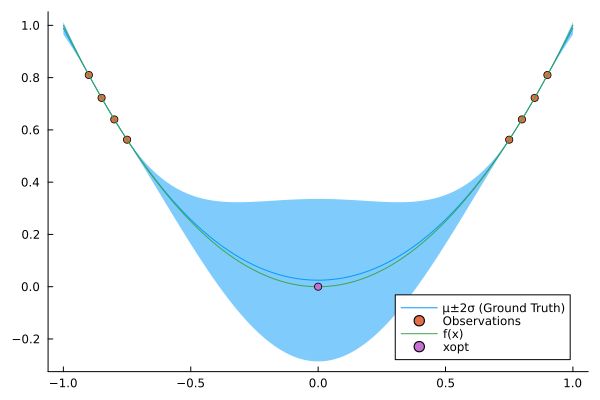

In [196]:
p = plot1D(sur; xmin=first(lbs), xmax=first(ubs))
xx = range(testfn.bounds[1,1], testfn.bounds[1,2], length=250)
plot!(xx, (x) -> testfn([x]), label="f(x)")
scatter!(p, [xy[1] for xy in testfn.xopt], [testfn(xy) for xy in testfn.xopt], label="xopt")

In [197]:
domain = first(lbs):.01:first(ubs)
dense_evals = zeros(length(domain), 4)
dense_evals2 = zeros(length(domain), 4)


for (i, x0) in enumerate(domain)
    print("|")
    tp.x0[:] = [x0]

    outcome = simulate_trajectory(sur, tp, initial_guesses, variance_reduction=true,
        candidate_locations=candidate_locations, candidate_values=candidate_values
    )
    dense_evals[i, :] .= [outcome[1], first(outcome[2]), outcome[3], first(outcome[4])]
    outcome = simulate_trajectory(sur, tp, initial_guesses, variance_reduction=false,
        candidate_locations=candidate_locations, candidate_values=candidate_values
    )
    dense_evals2[i, :] .= [outcome[1], first(outcome[2]), outcome[3], first(outcome[4])]
    
end

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

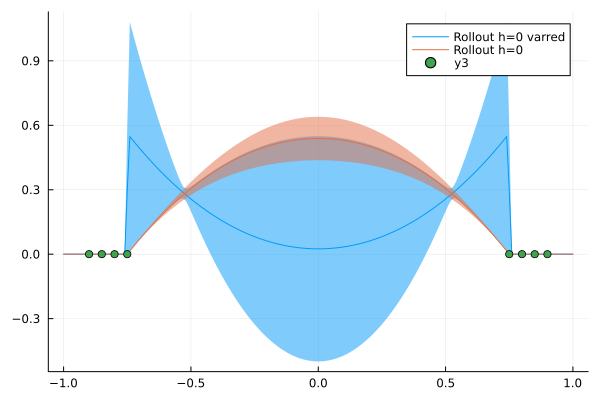

In [198]:
plot(
    domain,
    dense_evals[:, 1],
    ribbons=dense_evals[:, 3],
    label="Rollout h=$HORIZON varred"
)
plot!(
    domain,
    dense_evals2[:, 1],
    ribbons=dense_evals2[:, 3],
    label="Rollout h=$HORIZON"
)
scatter!(sur.X', zeros(length(sur.X')))

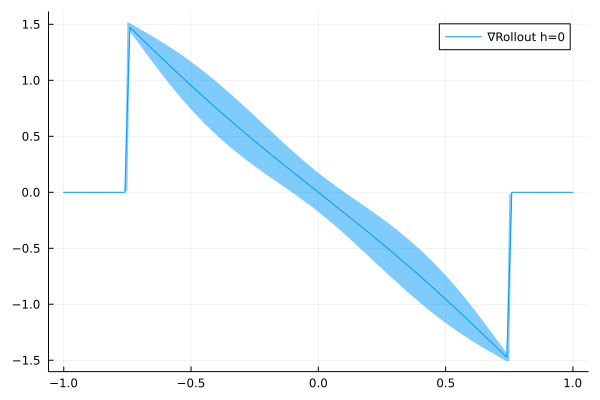

In [199]:
plot(
    domain,
    dense_evals[:, 2],
    ribbons=dense_evals[:, 4],
    label="∇Rollout h=$HORIZON"
)
# plot!(domain, fd_evals)

In [106]:
# Optim.Options(x_tol=1e-3, f_tol=1e-3)
function rollout_constructor(
    s::RBFsurrogate,
    tp::TrajectoryParameters,
    xstarts::Matrix{Float64};
    variance_reduction::Bool=false,
    candidate_locations::SharedMatrix{Float64},
    candidate_values::SharedArray{Float64})
    function rollout(x)
        tp.x0[:] = x
        @timeit to "rollout" begin μx, ∇μx, _, _ = simulate_trajectory(sur, tp, xstarts,
            variance_reduction=variance_reduction,
            candidate_locations=candidate_locations,
            candidate_values=candidate_values
        )
        end

        return -μx
    end

    function grollout!(g, x)
        tp.x0[:] = x
        @timeit to "grollout" begin μx, ∇μx, _, _ = simulate_trajectory(sur, tp, xstarts,
            variance_reduction=variance_reduction,
            candidate_locations=candidate_locations,
            candidate_values=candidate_values
        )
        end
        g[:] = -∇μx
    end

    return (rollout, grollout!)
end

rollout, grollout! = rollout_constructor(
    sur, tp, initial_guesses,
    candidate_locations=candidate_locations,
    candidate_values=candidate_values,
    variance_reduction=false
)

(rollout, grollout!)

In [111]:
results = []
xstarts = range(first(lbs) + .01, first(ubs) - .01, length=16)

begin
reset_timer!(to)
@timeit to "Solve Rollout" begin
    for x in [1.]
        println("Solving Acquisition Iteratively Starting at $(x)")
        push!(
            results,
            optimize(
                rollout, grollout!, [x], LBFGS(), Optim.Options(x_tol=1e-3, f_tol=1e-3)
            )
        )
    end
end
show(to, allocations=false)
end

Solving Acquisition Iteratively Starting at 1.0
 ───────────────────────────────────────────────
                                  Time          
                         ───────────────────────
    Tot / % measured:         11.4s / 100.0%    

 Section         ncalls     time    %tot     avg
 ───────────────────────────────────────────────
 Solve Rollout        1    11.4s  100.0%   11.4s
   grollout          22    5.77s   50.4%   262ms
   rollout           22    5.68s   49.6%   258ms
 ───────────────────────────────────────────────

In [112]:
xx = first.(Optim.minimizer.(results))
yy = -Optim.minimum.(results)

1-element Vector{Float64}:
 0.6977083065445483

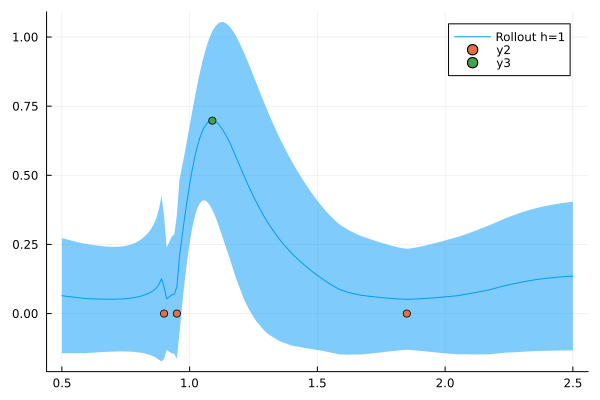

In [113]:
plot(
    domain,
    dense_evals[:, 1],
    ribbons=dense_evals[:, 3],
    label="Rollout h=$HORIZON"
)
scatter!(sur.X', zeros(length(sur.X')))
scatter!(xx, yy)

In [73]:
using Optim, OptimTestProblems
prob = UnconstrainedProblems.examples["Rosenbrock"];

In [74]:
f(x    ) =  @timeit to "f"  prob.f(x)
g!(x, g) =  @timeit to "g!" prob.g!(x, g)
h!(x, h) =  @timeit to "h!" prob.h!(x, h)

begin
reset_timer!(to)
@timeit to "Trust Region" begin
    res = Optim.optimize(f, g!, h!, prob.initial_x, NewtonTrustRegion())
end
show(to; allocations = false)
end

 ──────────────────────────────────────────────
                                 Time          
                        ───────────────────────
    Tot / % measured:        446ms /  99.5%    

 Section        ncalls     time    %tot     avg
 ──────────────────────────────────────────────
 Trust Region        1    444ms  100.0%   444ms
   h!               24   3.27ms    0.7%   136μs
   g!               27   2.88ms    0.6%   107μs
   f                27   33.2μs    0.0%  1.23μs
 ──────────────────────────────────────────────

In [75]:
3000 / 60

50.0